In [1]:
using Revise

In [6]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase,
    Distributions,
    StructArrays,
    StaticArrays,
    StructArrays,
    LoopVectorization,
    Parameters,
    MutableNamedTuples

@consts begin
    λ = 626e-9
    Γ = 2π * 6.4e6
    m = @with_unit 57 "u"
    k = 2π / λ
    _μB = (μ_B / h) * 1e-4
    kB = 1.380649e-23
end
;

In [7]:
# create basis states
# ground_state1 = AngularMomentumState_Labelled(L=0, N=1, M=-1)
# ground_state2 = AngularMomentumState_Labelled(L=0, N=1, M=+1)
# excited_state1 = AngularMomentumState_Labelled(L=1, N=0, M=0)
# excited_state2 = AngularMomentumState_Labelled(L=2, N=0, M=0)
# basis = [ground_state1; ground_state2; excited_state1; excited_state2]

ground_state1 = AngularMomentumState_Labelled_v1(L=0, N=1, M=-1)
ground_state2 = AngularMomentumState_Labelled_v1(L=0, N=1, M=+1)
excited_state = AngularMomentumState_Labelled_v1(L=1, N=0, M=0)
basis = [ground_state1; ground_state2; excited_state]
;

In [8]:
# create basis states
ground_state1 = AngularMomentumState_Labelled_v1(L=0, N=1, M=-1)
ground_state2 = AngularMomentumState_Labelled_v1(L=0, N=1, M=+1)
excited_state1 = AngularMomentumState_Labelled_v1(L=1, N=0, M=0)
excited_state2 = AngularMomentumState_Labelled_v1(L=2, N=0, M=0)
basis = [ground_state1; ground_state2; excited_state1; excited_state2]
;

In [69]:
# 2-level system
ground_state1 = AngularMomentumState_Labelled_v1(L=0, N=1, M=-1)
excited_state = AngularMomentumState_Labelled_v1(L=1, N=0, M=0)
basis = [ground_state1; excited_state]
;

In [70]:
# create Hamiltonian
operator = :(
    T * L +
    Bz * Zeeman_L0
)

parameters = @params begin
    T = 4.789016900958466e14
    Bz = 1e-6
end

H = Hamiltonian(basis=basis, operator=operator, parameters=parameters)
;

In [795]:
# solve the Hamiltonian
evaluate!(H)
QuantumStates.solve!(H)
states = H.states

# calculate the transition dipole moments
update_basis_tdms!(H)
update_tdms!(H)
d = H.tdms

d ./= d[1,2,3]
;

In [1127]:
Isat = π*h*c*Γ / (3λ^3)
s * Isat * 1e-4

68.19808639080266

In [1440]:
# beam parameters
δ_ = 100Γ
# s = 3δ_^2 / (Γ * maximum(norm.(d)))^2 # Ω = sqrt(3/2)*δ
s = 2δ_^2 / (Γ * maximum(norm.(d)))^2 # Ω = δ

ϵ_func(ϵ) = t -> ϵ
s_func(s) = (r,t) -> s

# ω01 = 2π * energy(H.states[3]) # σ⁺ drives to state 3
# ω02 = 2π * energy(H.states[4]) # σ⁻ drives to state 4

# for 2-level system
ω01 = 2π * energy(H.states[2]) # 

# ### 2-COLOR FORCE ###
# Δ1 = +0Γ #+ 10Γ
# Δ2 = -15Γ #+ 10Γ
# χ1 = +π/4
# χ2 = -π/4

### 4-COLOR FORCE ###
Δ1 = +0Γ #+ 10Γ
Δ2 = -0Γ #+ 10Γ
χ1 = +π/6
χ2 = -π/6

## BCF FORCE BEAMS ##
# ingoing beam
ω1 = ω01 + δ_ + Δ1; k1 = +ẑ; ϵ1 = exp(+im*χ1/2) .* σ⁺; laser1 = Field(k1, ϵ_func(ϵ1), ω1, s_func(s))
ω2 = ω01 - δ_ + Δ1; k2 = +ẑ; ϵ2 = exp(-im*χ1/2) .* σ⁺; laser2 = Field(k2, ϵ_func(ϵ2), ω2, s_func(s))

# retro beam
ω3 = ω01 + δ_ - Δ1; k3 = -ẑ; ϵ3 = exp(-im*χ1/2) .* σ⁺; laser3 = Field(k3, ϵ_func(ϵ3), ω3, s_func(s))
ω4 = ω01 - δ_ - Δ1; k4 = -ẑ; ϵ4 = exp(+im*χ1/2) .* σ⁺; laser4 = Field(k4, ϵ_func(ϵ4), ω4, s_func(s))

# ingoing beam
ω5 = ω02 + δ_ + Δ2; k5 = +ẑ; ϵ5 = exp(+im*χ2/2) .* σ⁻; laser5 = Field(k5, ϵ_func(ϵ5), ω5, s_func(s))
ω6 = ω02 - δ_ + Δ2; k6 = +ẑ; ϵ6 = exp(-im*χ2/2) .* σ⁻; laser6 = Field(k6, ϵ_func(ϵ6), ω6, s_func(s))

# retro beam
ω7 = ω02 + δ_ - Δ2; k7 = -ẑ; ϵ7 = exp(-im*χ2/2) .* σ⁻; laser7 = Field(k7, ϵ_func(ϵ7), ω7, s_func(s))
ω8 = ω02 - δ_ - Δ2; k8 = -ẑ; ϵ8 = exp(+im*χ2/2) .* σ⁻; laser8 = Field(k8, ϵ_func(ϵ8), ω8, s_func(s))

## EXTRA BEAMS FOR 4-COLOR ##
ω9 = ω01 + 3δ_ + Δ1; k9 = +ẑ; ϵ9 = exp(+im*χ1/2) .* σ⁺; laser9 = Field(k9, ϵ_func(ϵ9), ω9, s_func(s))
ω10 = ω01 - 3δ_ + Δ1; k10 = +ẑ; ϵ10 = exp(-im*χ1/2) .* σ⁺; laser10 = Field(k10, ϵ_func(ϵ10), ω10, s_func(s))

# retro beam
ω11 = ω01 + 3δ_ - Δ1; k11 = -ẑ; ϵ11 = exp(-im*χ1/2) .* σ⁺; laser11 = Field(k11, ϵ_func(ϵ11), ω11, s_func(s))
ω12 = ω01 - 3δ_ - Δ1; k12 = -ẑ; ϵ12 = exp(+im*χ1/2) .* σ⁺; laser12 = Field(k12, ϵ_func(ϵ12), ω12, s_func(s))

# ingoing beam
ω13 = ω02 + 3δ_ + Δ2; k5 = +ẑ; ϵ5 = exp(+im*χ2/2) .* σ⁻; laser13 = Field(k5, ϵ_func(ϵ5), ω5, s_func(s))
ω14 = ω02 - 3δ_ + Δ2; k6 = +ẑ; ϵ6 = exp(-im*χ2/2) .* σ⁻; laser14 = Field(k6, ϵ_func(ϵ6), ω6, s_func(s))

# retro beam
ω15 = ω02 + 3δ_ - Δ2; k7 = -ẑ; ϵ7 = exp(-im*χ2/2) .* σ⁻; laser15 = Field(k7, ϵ_func(ϵ7), ω7, s_func(s))
ω16 = ω02 - 3δ_ - Δ2; k8 = -ẑ; ϵ8 = exp(+im*χ2/2) .* σ⁻; laser16 = Field(k8, ϵ_func(ϵ8), ω8, s_func(s))

# lasers = [laser1, laser2, laser3, laser4, laser5, laser6, laser7, laser8]
# lasers = [laser1, laser2, laser3, laser4, laser5, laser6, laser7, laser8, laser9, laser10, laser11, laser12, laser13, laser14, laser15, laser16]
lasers = [laser1, laser2, laser3, laser4, laser9, laser10, laser11, laser12]
# lasers = [laser1, laser2, laser3, laser4]
;

In [1441]:
using LoopVectorization
function update_H_and_∇H(H, p, r, t)
    
    # Define a ramping magnetic field
    Zeeman_Hz = p.extra_data.Zeeman_Hz
    Bz = p.sim_params.B_offset[3]
    
    @turbo for i in eachindex(H)
        H.re[i] = Bz * Zeeman_Hz.re[i]
        H.im[i] = Bz * Zeeman_Hz.im[i]
    end
    
    ∇H = SVector{3, Float64}(0,0,0)
    
    return ∇H
end
;

In [1442]:
Zeeman_z(state, state′) = Zeeman_L0(state, state′, 0)
Zeeman_z_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_z, [H.states[1]], [H.states[2]]) .* (2π*gS*_μB/Γ))

extra_data = MutableNamedTuple(
    # Zeeman_Hx = Zeeman_x_mat,
    # Zeeman_Hy = Zeeman_y_mat,
    Zeeman_Hz = Zeeman_z_mat,
    lasers = lasers,
    states = states
)
sim_params = MutableNamedTuple(
    B_offset = (0., 0., 0.)
    )
;

In [1443]:
# Set initial conditions
particle = Particle()

ρ0 = zeros(ComplexF64, length(states), length(states))
ρ0[2,2] = 1.0

res = 1
freq_res = 1/10^res
p = obe(ρ0, particle, states, lasers, d, true, true; 
    sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, freq_res=freq_res, update_H_and_∇H=update_H_and_∇H)

p.r0 = (0., 0., 0.) .* 2π
p.v = (0., 0., 10) #./ (Γ / k)
p.v = round_vel(p.v, p.freq_res)

t_end = 10p.period
tspan = (0., t_end)

# prob.p.force_last_period = (0, 0, 0)
cb = PeriodicCallback(reset_force!, p.period)

prob = ODEProblem(ρ_updated!, p.ρ0_vec, tspan, p, callback=cb)
times = range(0, t_end, 10000)

# set actual k values
prob.p.fields.k .= prob.p.fields.k .* (Γ .* prob.p.fields.ω ./ c / k)

# round k values
for i ∈ eachindex(prob.p.fields.k)
    prob.p.fields.k[i] = (round(prob.p.fields.k[i][1], digits=res), round(prob.p.fields.k[i][2], digits=res), round(prob.p.fields.k[i][3], digits=res))
end
;

In [1444]:
# using BenchmarkTools
# dρ = deepcopy(p.ρ0_vec)
# @btime ρ_updated!($dρ, $p.ρ0_vec, $p, 0.0)

In [1445]:
@time sol = DifferentialEquations.solve(prob, DP5(), reltol=1e-4, abstol=1e-7, saveat=times, maxiters=1e7)
;

  4.231155 seconds (3.84 M allocations: 250.685 MiB, 4.86% gc time, 92.04% compilation time)


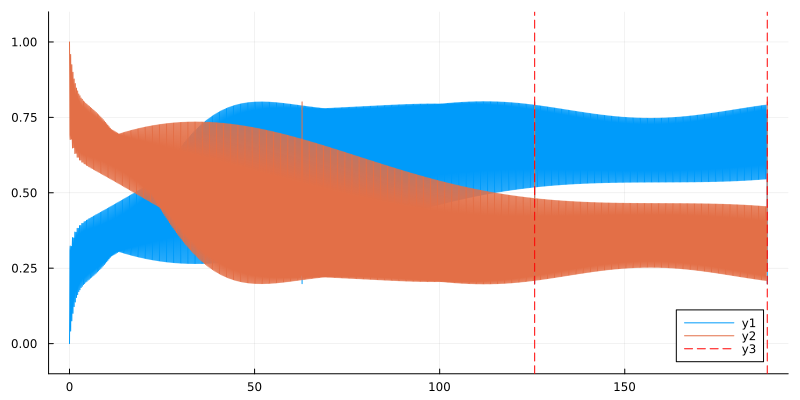

In [1446]:
using Plots
plot_us = sol.u#[1:10:end]
plot_ts = sol.t#[1:10:end]

n_states = size(prob.p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1))
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
# plot()
# plot!(plot_ts, [real(u[end]) for u in plot_us])
# plot!(plot_ts, [real(u[end-1]) for u in plot_us])
# plot!(plot_ts, [real(u[end-2]) for u in plot_us])
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)
# vline!([280, 380], color="red", linestyle=:dash)

In [1447]:
prob.p.ρ_soa |> diag |> sum

1.0000000000000073 + 0.0im

In [1448]:
prob.p.force_last_period #* (1e-3 * ħ * k * Γ / m)

3-element SVector{3, Float64} with indices SOneTo(3):
   0.0
   0.0
 -20.801785581110597

## Force versus velocity

In [1449]:
function prob_func(prob, i, repeat)
    prob.p.r0 = scan_params[i].r
    prob.p.v = (0., 0., scan_params[i].v)
    prob.p.force_last_period = SVector(0.,0.,0.)
    return prob
end
function output_func(sol, i)
    f = sol.prob.p.force_last_period
    return (f, false) #[3] #(f ⋅ p.v) / norm(p.v)
end
;

In [1450]:
using RectiGrids

di = 0
# rs = vcat([(n1/(di+1), n2/(di+1), n3/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
rs = vcat([(n1/(di+1), n2/(di+1), 0.25) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = (0:1:90) #./ (Γ / k)

scan_values = (r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
scan_params = scan_values_grid
;

In [1451]:
ensemble_prob = EnsembleProblem(prob, prob_func=prob_func)
@time ensemble_sol = solve(ensemble_prob, DP5(), EnsembleThreads(), trajectories=length(scan_params), reltol=1e-4, save_on=false)
;

  5.486906 seconds (1.21 M allocations: 82.458 MiB, 1.12% gc time, 238.88% compilation time)


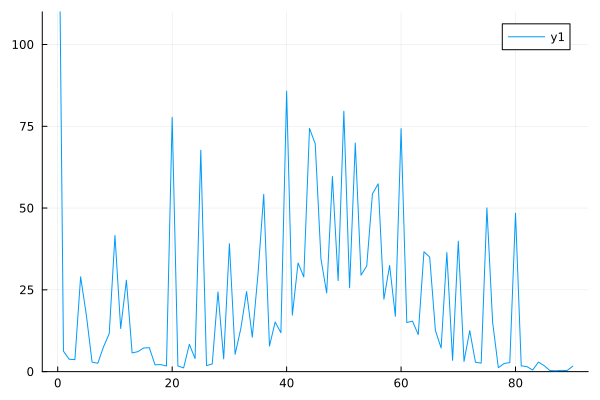

In [1453]:
plot(vs, -[sol.prob.p.force_last_period[3] for sol ∈ ensemble_sol] .* 2, ylim=(0,110))

### Scan over saturation parameter $s$

In [228]:
s_prefactor = (δ_ / (Γ * maximum(norm.(d))))^2

s_factors = 3.4:0.02:3.5
ensemble_sols = []

for s_factor ∈ s_factors
    
    # set intensity
    s = s_prefactor * s_factor
    prob.p.fields.s_func .= s_func(s)

    ensemble_prob = EnsembleProblem(prob, prob_func=prob_func)
    @time ensemble_sol = solve(ensemble_prob, DP5(), EnsembleThreads(), trajectories=length(scan_params), reltol=1e-4, save_on=false)

    push!(ensemble_sols, ensemble_sol)
end 

  4.320405 seconds (24.13 k allocations: 3.175 MiB)
  4.561265 seconds (24.40 k allocations: 3.197 MiB)
  4.414916 seconds (24.27 k allocations: 3.187 MiB)
  4.703719 seconds (24.27 k allocations: 3.187 MiB)
  4.652004 seconds (24.27 k allocations: 3.188 MiB)
  4.197974 seconds (24.25 k allocations: 3.184 MiB)


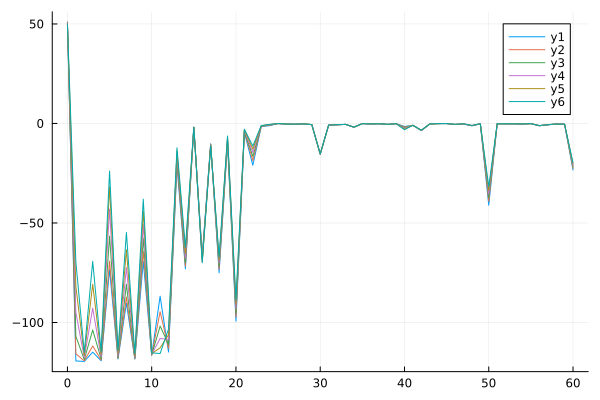

In [230]:
plot()
for ensemble_sol ∈ ensemble_sols
    plot!(vs, [sol.prob.p.force_last_period[3] for sol ∈ ensemble_sol] .* 2)
end
plot!()